# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import pandas as pd
import seaborn as sns
from data.data_cleaning import remove_nullrows, median_imputation, abbreviate_features, remove_redundant_features

# Define Path Constants

In [3]:
RAW_PATH = "../data/unprocessed/IMT_Classification_Dataset_matminer_and_handbuilt_v9.xlsx"
SAVE_PATH = "../data/processed/IMT_Classification_Dataset_Processed_v9.xlsx"

# Exploratory Data Analysis

## 1. Read in the [unprocessed dataset](https://github.com/rpw199912j/mit_model_code/blob/master/data/unprocessed/IMT_Classification_Dataset_matminer_and_handbuilt_v9.xlsx)

In [4]:
df_raw = pd.read_excel(RAW_PATH)
df_raw

,Compound,Label,struct_file_path,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,TiS2,0,../data/Structures/Metals/TiS2_52195.cif,16,22,6,18.000000,2.666667,16,43,...,3.460133,3.407300,3.442522,-30.566774,20.696172,43.267170,99.29900,51.805713,6.792914,19.087398
1,SrOsO3,0,../data/Structures/Metals/SrOsO3-Springer.cif,8,76,68,27.600000,23.520000,8,8,...,3.248982,2.859021,2.962374,-42.747293,23.484681,41.000000,55.00000,10.347625,10.509724,12.232597
2,SrRuO3,0,../data/Structures/Metals/SrRuO3_75561.cif,8,44,36,21.200000,15.840000,8,8,...,3.579973,2.760023,2.947568,-44.758483,23.738172,45.000000,59.00000,10.330721,8.527722,12.089967
3,OsO2,0,../data/Structures/Metals/OsO2_15070.cif,8,76,68,30.666667,30.222222,8,57,...,2.805520,2.442651,2.684563,-44.387080,25.269881,41.000000,55.00000,9.953087,13.687053,10.747095
4,SrLaCuO4,0,../data/Structures/Metals/LaSrCuO4_10252.cif,8,57,49,22.285714,16.326531,8,8,...,3.421841,2.662257,2.966018,-36.448400,23.905465,36.841000,57.38000,18.524833,8.820620,13.436088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,YbFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YbCu3Fe...,8,70,62,17.850000,11.820000,8,39,...,2.924013,2.552849,2.744642,-33.639068,24.360992,36.841000,57.38000,16.597335,7.361181,9.750947
280,NiSeS,2,../data/Structures/MIT_materials/HighT/NiS(2-x...,16,34,18,26.000000,6.666667,16,61,...,3.287898,2.376963,3.060164,-18.496007,9.778249,18.168838,35.18700,13.516153,8.891048,16.385810
281,Ti2O3,2,../data/Structures/MIT_materials/HighT/Ti2O3_H...,8,22,14,13.600000,6.720000,8,43,...,2.900002,2.771288,2.844355,-33.753924,24.648770,27.491710,43.26717,11.068473,16.169806,10.490597
282,Ca1.2La2.8Mn4O12,2,../data/Structures/MIT_materials/HighT/La0.7Ca...,8,57,49,18.980000,13.176000,8,7,...,3.516261,2.747250,2.906344,-39.888114,22.934073,38.930600,57.57000,14.915598,8.843086,11.576092


We can see that there are 284 rows and 168 columns. Since the `Compound` and `struct_file_path` columns are not predictors and `Label` column is the target/response column, in addition to the fact that `struct_ordered` and `struct_disordered` are just the one-hot encoded version of same categorical feature [is_ordered](https://pymatgen.org/pymatgen.core.structure.html#pymatgen.core.structure.SiteCollection.is_ordered) from Pymatgen, we have **284** compounds and **164** predictors in the unprocessed dataset.

That being said, there are also compounds that have multiple entries in the unprocessed dataset. For instance, some MIT compounds have both a high-temperature structure and a low-temperature structure (i.e. one structure above the transition temperature and another below the transition temperature). As a result, we will only keep 1 entry for each unique compound from now on.

In [5]:
# first sort the compounds by label and compound name alphabetically
df_raw = df_raw.sort_values(by=["Label", "Compound"], ignore_index=True)
# if there are multiple entries, preserve the last one
df_raw = df_raw.drop_duplicates(subset="Compound", keep="last")
df_raw

,Compound,Label,struct_file_path,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_291573.cif,8,56,48,24.400000,19.680000,8,9,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaNiS2,0,../data/Structures/Metals/BaNiS2_246945.cif,16,56,40,29.000000,13.500000,16,9,...,3.783737,3.137645,3.654519,-21.082598,20.132993,18.168838,35.187000,12.893512,21.595766,21.929081
2,BaOsO3,0,../data/Structures/Metals/BaOsO3-Springer.cif,8,76,68,31.200000,27.840000,8,9,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
3,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_73787.cif,8,83,75,28.181818,25.685950,8,56,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
4,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7.cif,8,44,36,17.000000,10.500000,8,7,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,V6O13,2,../data/Structures/MIT_materials/HighT/V6O13_H...,8,23,15,12.736842,6.481994,8,46,...,3.269140,2.461773,2.767633,-32.743339,35.209237,65.281650,128.125000,58.592940,-12.467020,11.494831
277,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,8,23,15,13.217391,6.805293,8,46,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
280,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,8,23,15,13.000000,6.666667,8,46,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
281,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3-6...,8,39,31,18.200000,12.240000,8,12,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816


As we can see, there are **229** unique compounds.

## 2. Explore missing values

### By column

In [6]:
columns_na_info = pd.DataFrame(df_raw.isna().sum(), columns=["num_na"])

In [7]:
columns_na_info[columns_na_info.num_na != 0]

,num_na
gii,50
max_mm_dists,1
min_mm_dists,1
avg_mm_dists,1
max_mx_dists,1
min_mx_dists,1
avg_mx_dists,1
v_m,2
v_x,1
iv,4


### By row

In [8]:
rows_na_info = pd.DataFrame(df_raw.isna().sum(axis=1), columns=["num_na"])
pd.merge(df_raw[["Compound"]], rows_na_info[rows_na_info.num_na != 0].sort_values(by="num_na", ascending=False),
         left_index=True, right_index=True, how="right")

,Compound,num_na
136,SiO2,11
39,V7O13,6
73,CoSb3,5
72,CoP3,4
70,CoAs3,2
13,LiTi2O4,1
189,CaFe4(CuO4)3,1
153,Sr2NbFeO6,1
159,Sr4.002La1.998Fe6O17.874,1
160,Sr8Fe8O22.45104,1


## 3. Explore target variable

In [9]:
df_raw.Label.value_counts()

1    126
2     62
0     41
Name: Label, dtype: int64

Here is a table that shows what each value mean in the target variable

|value|meaning|
|:----|:------|
|2    |MIT    |
|1    |Insulator|
|0    |Metal  |

We can immediately see that if we were to make a classification model, the input dataset is **imbalanced**.

## 4. Predictor correlation

### Randomly sample 10 features to create a correlation matrix

In [10]:
corr_df = df_raw.drop(columns="Label").sample(n=10, axis=1, random_state=31415926).corr()

### Make a heatmap

<AxesSubplot:>

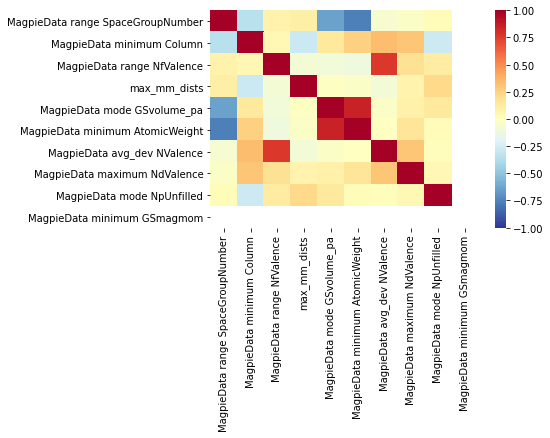

In [11]:
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap="RdYlBu_r")

### See the correlation between the MendeleevNumber features

In [12]:
mendeleev_df = df_raw.filter(like="MendeleevNumber", axis=1)
mendeleev_df

,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber
0,9,87,78,64.000000,27.600000,87
1,9,88,79,61.500000,26.500000,88
2,9,87,78,65.400000,25.920000,87
3,56,87,31,81.181818,9.157025,87
4,7,87,80,61.833333,29.361111,87
...,...,...,...,...,...,...
276,46,87,41,74.052632,17.717452,87
277,46,87,41,72.739130,18.601134,87
280,46,87,41,73.333333,18.222222,87
281,12,87,75,66.800000,24.240000,87


In [13]:
mendeleev_df.corr()

,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber
MagpieData minimum MendeleevNumber,1.000000,0.016143,-0.999654,0.840651,-0.875276,-0.222038
MagpieData maximum MendeleevNumber,0.016143,1.000000,0.010145,-0.060685,0.105759,-0.064844
MagpieData range MendeleevNumber,-0.999654,0.010145,1.000000,-0.842312,0.878125,0.220351
MagpieData mean MendeleevNumber,0.840651,-0.060685,-0.842312,1.000000,-0.977660,0.071612
MagpieData avg_dev MendeleevNumber,-0.875276,0.105759,0.878125,-0.977660,1.000000,0.054959
MagpieData mode MendeleevNumber,-0.222038,-0.064844,0.220351,0.071612,0.054959,1.000000


<AxesSubplot:>

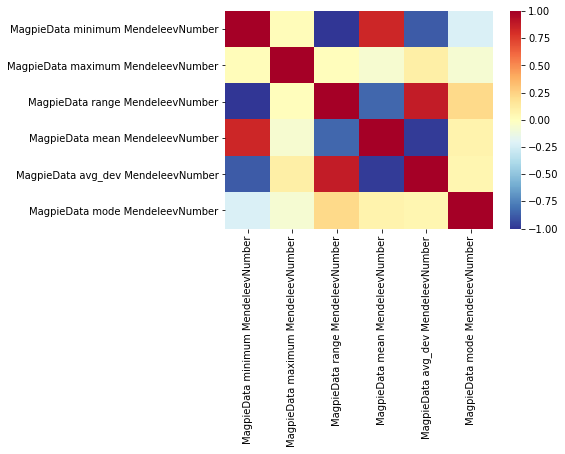

In [14]:
sns.heatmap(mendeleev_df.corr(), vmin=-1, vmax=1, center=0, cmap="RdYlBu_r")

# Data cleaning workflow

## 1. Remove rows with more than 6 NaN values

In [15]:
df_processed = remove_nullrows(df_raw, 6)

In [16]:
df_processed.shape[0] - df_raw.shape[0]

-1

We can see that we only dropped 1 row after this step, which is SiO$_2$.

## 2. Impute the missing values with the median of the corresponding feature within each label group

We first group the dataframe by the column `Label`, find the median for each column within each `Label` group and then impute the missing values with those medians.

In [17]:
df_processed = median_imputation(df_processed)

We can also confirm if all the missing values are indeed filled with mean values.

In [18]:
pd.DataFrame(df_processed.isna().sum(), columns=["num_na"])[columns_na_info.num_na != 0]

,num_na
gii,0
max_mm_dists,0
min_mm_dists,0
avg_mm_dists,0
max_mx_dists,0
min_mx_dists,0
avg_mx_dists,0
v_m,0
v_x,0
iv,0


## 3. Rename the columns for easier readability and plotting

In the heatmap, you might see that there are feautures with a "MagpieData" prefix. This step delete all those prefixes from the variable names and fill the white space with underscore.

In [19]:
df_processed = abbreviate_features(df_processed)

## 4. Remove columns with zero variance and high correlations

In [20]:
df_processed = remove_redundant_features(df_processed)

In [21]:
df_processed.shape[1] - df_raw.shape[1]

-61

Just by removing the zero-variance & highly correlated columns, we reduce the number of columns by 61.

Now that we have 228 compounds, we can also check the number of compounds for each class after cleaning.

In [22]:
df_processed.Label.value_counts()

1    125
2     62
0     41
Name: Label, dtype: int64

## 5. Save the processed dataset

In [23]:
df_processed.to_excel(SAVE_PATH, index=False)
df_processed

,Compound,Label,struct_file_path,maximum_MendeleevNumber,range_MendeleevNumber,avg_dev_MendeleevNumber,range_AtomicWeight,mean_AtomicWeight,avg_dev_AtomicWeight,mode_AtomicWeight,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volume_per_site
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_291573.cif,87,78,27.600000,121.32760,56.257040,48.309168,15.9994,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaNiS2,0,../data/Structures/Metals/BaNiS2_246945.cif,88,79,26.500000,105.26200,65.037600,36.144700,32.0650,...,3.783737,3.137645,3.654519,-21.082598,20.132993,18.168838,35.187000,12.893512,21.595766,21.929081
2,BaOsO3,0,../data/Structures/Metals/BaOsO3-Springer.cif,87,78,25.920000,174.23060,75.111040,70.933968,15.9994,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
3,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_73787.cif,87,31,9.157025,192.98100,66.554236,64.342519,15.9994,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
4,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7.cif,87,80,29.361111,85.07060,36.197483,23.564431,15.9994,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,V6O13,2,../data/Structures/MIT_materials/HighT/V6O13_H...,87,41,17.717452,34.94210,27.033747,15.099633,15.9994,...,3.269140,2.461773,2.767633,-32.743339,35.209237,65.281650,128.125000,58.592940,-12.467020,11.494831
277,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,87,41,18.601134,34.94210,28.153174,15.852749,15.9994,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
280,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,87,41,18.222222,34.94210,27.646767,15.529822,15.9994,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
281,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3-6...,87,75,24.240000,72.90645,39.119490,27.744108,15.9994,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816
